# Problem statement
Aim of this project is to build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Methodology
Model development is divided into multiple steps as mentioned below,

- Train-val split: This step involves spliting the dataset into train and validation parts.
- Data Visualization: This step involves visualizing our dataset. We can also check number of images availalbe for each class.
- Model Development: This steps involves training the model and validate it. It involves evaluating the model using relevant matrics.
- Data Augmentation: This part involves data augmentation and balancing the dataset amongst various classses. Here we generally rotate or flip or change color intensity/brightness or change color weights etc for the images. It increases the size of the dataset and improves the model against overfitting problem.
- Model Development (on augmented dataset): This steps involves training the model and validate it. It involves evaluating the model using relevant matrics.
- Conclusion/Recommendation: It involves drawing conclusions and recommendations to business.

### Importing Dependencies

In [ ]:
# Dependancies 

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

CNN is computationally expensive algorithm and demands TPU/GPU to train it quickly. Hence, we would be using Google Colab to train our models. Google Colab provides limited access to GPU/TPU machines with 0 cost.


In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "gdrive/My Drive/skin_data.zip" -d ""

Archive:  gdrive/My Drive/skin_data.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer

In [ ]:
# Defining the path for train and test images (location in google drive where images are stored)

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [ ]:
# Checking number of images in respective train/test folders

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# 1. Train-val split

Train and Test folders contains 2239 and 118 images respectively. It includes all the classes.

In [ ]:
# Defining image resolution and batch size for training purpose

batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Reading images from train folder and splitting into test and validation sets

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=123,
    subset="training")


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=123,
    subset="validation")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
print(train_ds)
print(val_ds)

<BatchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int32)>


In [ ]:
# Checking classes for train images

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 2. Data Vizualization

In [ ]:
# Plotting images from dataset

# plt.figure(figsize=(10, 10))
# import random
# class_labels = []
# k = 1

# while set(class_labels) != set(class_names):
#   for images, labels in train_ds.take(random.randint(0, int(image_count_train/batch_size))):
#     for i in range(batch_size):
#       if class_names[labels[i]] not in class_labels:
#         ax = plt.subplot(3, 3, k)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
#         class_labels.append(class_names[labels[i]])
#         k += 1


Dataset includes 9 different types of skin problems and out of them `melanoma` is related to skin cancer and dangerous to health.

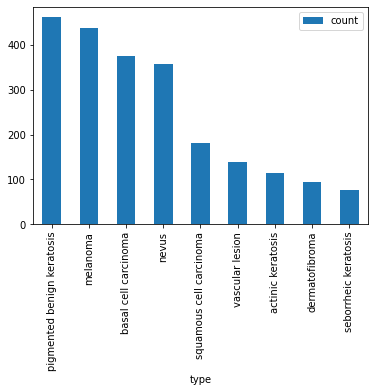

In [ ]:
# plotting initial data distribution

count_im = []
for i in class_names:
  count_im .append([i, len(list(data_dir_train.glob(i+'/*.jpg')))])

count_im_df = pd.DataFrame(count_im, columns=['type', 'count']).sort_values('count', ascending = False)

count_im_df.plot.bar(x = 'type', y = 'count')
plt.show()

Observations,
- Data distribution is skewed. `pigmented benign keratosis` is having highest count where as `seborrheic keratosis` is having least count.
- Data augmentation and balancing may help but before doing so we would check model performance with original data.

# 3. Model Development

In [ ]:
num_classes = 9
results = []

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 8)       224       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 100, 100, 16)      1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 128)       18560     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 80000)            

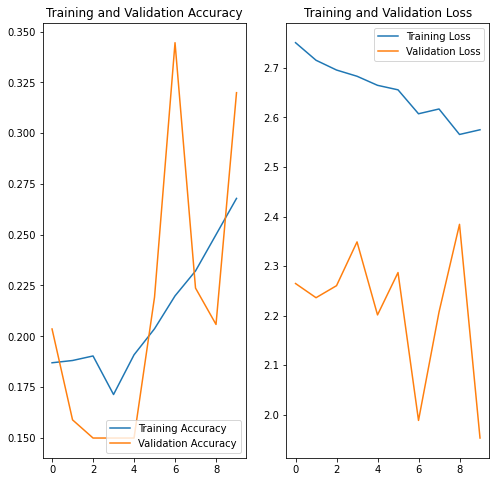

In [ ]:
# Model Definition
model_0 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(8, 3, padding='same', activation='relu'),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(num_classes)])


# Compile model
model_0.compile(optimizer='SGD',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


# Model Summary
model_0.summary()

class_weight = {count_im_df.index[0]: (count_im_df['count'].sum()/(9*count_im_df['count'][0])),
                count_im_df.index[1]: (count_im_df['count'].sum()/(9*count_im_df['count'][1])),
                count_im_df.index[2]: (count_im_df['count'].sum()/(9*count_im_df['count'][2])),
                count_im_df.index[3]: (count_im_df['count'].sum()/(9*count_im_df['count'][3])),
                count_im_df.index[4]: (count_im_df['count'].sum()/(9*count_im_df['count'][4])),
                count_im_df.index[5]: (count_im_df['count'].sum()/(9*count_im_df['count'][5])),
                count_im_df.index[6]: (count_im_df['count'].sum()/(9*count_im_df['count'][6])),
                count_im_df.index[7]: (count_im_df['count'].sum()/(9*count_im_df['count'][7])),
                count_im_df.index[8]: (count_im_df['count'].sum()/(9*count_im_df['count'][8]))}
    
# Run model
epochs = 10
history = model_0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight = class_weight)


# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_0:Vanilla', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_data = test_datagen.flow_from_directory('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/',
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


Y_pred = model_0.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(' ')
print(classification_report(test_data.classes, y_pred))

Found 118 images belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[ 0  8  0  6  0  2  0  0  0]
 [ 0 10  0  5  0  1  0  0  0]
 [ 0  8  0  6  0  2  0  0  0]
 [ 0 12  0  3  0  1  0  0  0]
 [ 0 10  0  5  0  1  0  0  0]
 [ 0 10  0  3  0  3  0  0  0]
 [ 0  1  0  1  0  1  0  0  0]
 [ 0  5  0  7  0  4  0  0  0]
 [ 0  2  0  0  0  1  0  0  0]]
 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.15      0.62      0.24        16
           2       0.00      0.00      0.00        16
           3       0.08      0.19      0.12        16
           4       0.00      0.00      0.00        16
           5       0.19      0.19      0.19        16
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3

    accuracy                           0.14       118
   macro avg       0.05      0.11      0.06       118
weighted avg       0.06      0.14      0.07       118



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It can be observed that,
- Model is overfitting the dataset just after initial few number of epochs. Hence, we an either reduce the complexities in the model or we can increase the size of the dataset and balance it across various classes.
- We would be using `Augmentor`, a data augmentation library. Here, we would try to randomly rotate the images by some angle(s) and increase the size of the dataset by 500 in each class. 
- Angular augmentation makes sense specifically for this dataset because all the images are circular in nature.

# 4. Data Augmentation

In [ ]:
# importing Augmentor library
!pip install Augmentor
import Augmentor

In [ ]:
# Augmenting the training dataset 

path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.3, max_left_rotation=25, max_right_rotation=25)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.5)
    p.zoom_random(probability=0.3, percentage_area=0.15, randomise_percentage_area=True, )
    p.flip_random(0.35)
    p.crop_random(0.2, percentage_area=0.2)
    p.sample(500)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEDC4B5F390>:   0%|          | 1/500 [00:00<00:59,  8.41 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEDC2520AD0>: 100%|██████████| 500/500 [00:13<00:00, 37.95 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEDC24F1790>: 100%|██████████| 500/500 [00:12<00:00, 38.52 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEDC2360F50>: 100%|██████████| 500/500 [00:13<00:00, 37.23 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEDC4E13050>: 100%|██████████| 500/500 [01:09<00:00,  7.18 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEDC4C19F90>: 100%|██████████| 500/500 [00:59<00:00,  8.45 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=120x90 at 0x7FEDC2307E50>: 100%|██████████| 500/500 [00:12<00:00, 39.62 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=204x153 at 0x7FEDC4860A90>:   0%|          | 1/500 [00:00<01:11,  6.97 Samples/s]                   

Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEDC4AF4FD0>: 100%|██████████| 500/500 [00:29<00:00, 16.72 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEDC2778050>:   0%|          | 1/500 [00:00<00:58,  8.53 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=120x90 at 0x7FEDC272B710>: 100%|██████████| 500/500 [00:12<00:00, 40.62 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEDC4BD0B10>: 100%|██████████| 500/500 [00:12<00:00, 39.28 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


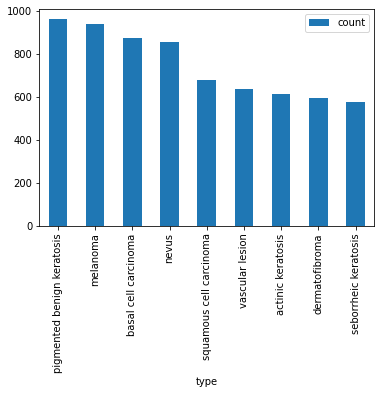

In [ ]:
# plotting initial data distribution

count_im = []
for i in class_names:
  count_im .append([i, len(list(data_dir_train.glob(i+'/*.jpg')))+len(list(data_dir_train.glob(i+'/output/*.jpg')))])

count_im_df = pd.DataFrame(count_im, columns=['type', 'count']).sort_values('count', ascending = False)

count_im_df.plot.bar(x = 'type', y = 'count')
plt.show()

Augmentor would create `output` folder in each of the class folder and insert 1000 augmented image belong to that particular class in it.

In [ ]:
# Redefining train and validation split 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=123,
    subset="training")


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/',
    labels='inferred',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=123,
    subset="validation")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Now we have 11239 images belong to train split and 2247 belong to validation split. This is a good number for a deep neural network to train upon.

#### Maximum utilization of available memory space

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 5. Model Development Experiments (with Data Augmentation and balancing)

 ### Design of Experiments
 
- Experiment 1: CNN network with conv+pooling+dense layers.
- Experiment 2: CNN network with conv+pooling+dense with dropout layers.
- Experiment 3: CNN network with conv+pooling+dense with batch normalization.
- Experiment 4: CNN network with conv+pooling+dense with dropout+batchnormalization.

### Experiment 1

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 64)       

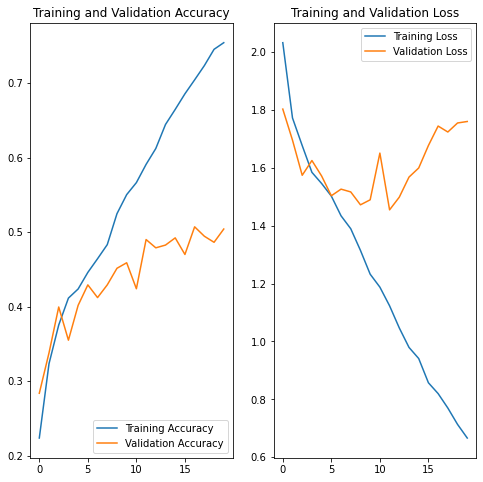

In [ ]:
# Model Definition
model_1 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)])


# Compile model
model_1.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


# Model Summary
model_1.summary()
    
    
class_weight = {count_im_df.index[0]: (count_im_df['count'].sum()/(9*count_im_df['count'][0])),
                count_im_df.index[1]: (count_im_df['count'].sum()/(9*count_im_df['count'][1])),
                count_im_df.index[2]: (count_im_df['count'].sum()/(9*count_im_df['count'][2])),
                count_im_df.index[3]: (count_im_df['count'].sum()/(9*count_im_df['count'][3])),
                count_im_df.index[4]: (count_im_df['count'].sum()/(9*count_im_df['count'][4])),
                count_im_df.index[5]: (count_im_df['count'].sum()/(9*count_im_df['count'][5])),
                count_im_df.index[6]: (count_im_df['count'].sum()/(9*count_im_df['count'][6])),
                count_im_df.index[7]: (count_im_df['count'].sum()/(9*count_im_df['count'][7])),
                count_im_df.index[8]: (count_im_df['count'].sum()/(9*count_im_df['count'][8]))}
    
# Run model
epochs = 20
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight = class_weight)


# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_1:Vanilla-Aug', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

In [ ]:
Y_pred = model_1.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(' ')
print(classification_report(test_data.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[ 3  2  3  1  2  2  0  2  1]
 [ 2  5  0  1  4  2  0  2  0]
 [ 2  1  1  1  3  3  1  3  1]
 [ 0  1  2  2  6  2  0  2  1]
 [ 1  2  0  1  4  2  2  4  0]
 [ 3  1  4  0  3  1  0  3  1]
 [ 0  1  0  1  1  0  0  0  0]
 [ 1  1  0  1 11  0  0  1  1]
 [ 0  0  0  0  2  1  0  0  0]]
 
              precision    recall  f1-score   support

           0       0.25      0.19      0.21        16
           1       0.36      0.31      0.33        16
           2       0.10      0.06      0.08        16
           3       0.25      0.12      0.17        16
           4       0.11      0.25      0.15        16
           5       0.08      0.06      0.07        16
           6       0.00      0.00      0.00         3
           7       0.06      0.06      0.06        16
           8       0.00      0.00      0.00         3

    accuracy                           0.14       118
   macro avg       0.13      0.12      0.12       118
weighted avg       0.16      0.14      0.15       118



It can be observed that, with the use of augmented dataset overfitting is reduced to some extent. Hovever there is still some room for improvement. Let's try some more methods against overfitting on the top.

### Experiment 2: Using Dropout layer

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)       

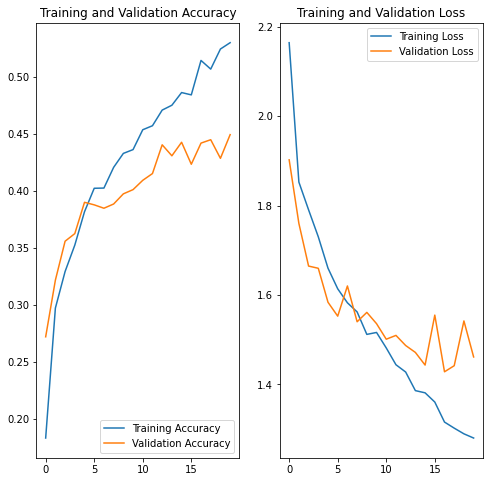

In [ ]:
# Model Definition
model_2 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes)])


# Compile model
model_2.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


# Model Summary
model_2.summary()
    
    
class_weight = {count_im_df.index[0]: (count_im_df['count'].sum()/(9*count_im_df['count'][0])),
                count_im_df.index[1]: (count_im_df['count'].sum()/(9*count_im_df['count'][1])),
                count_im_df.index[2]: (count_im_df['count'].sum()/(9*count_im_df['count'][2])),
                count_im_df.index[3]: (count_im_df['count'].sum()/(9*count_im_df['count'][3])),
                count_im_df.index[4]: (count_im_df['count'].sum()/(9*count_im_df['count'][4])),
                count_im_df.index[5]: (count_im_df['count'].sum()/(9*count_im_df['count'][5])),
                count_im_df.index[6]: (count_im_df['count'].sum()/(9*count_im_df['count'][6])),
                count_im_df.index[7]: (count_im_df['count'].sum()/(9*count_im_df['count'][7])),
                count_im_df.index[8]: (count_im_df['count'].sum()/(9*count_im_df['count'][8]))}
    
# Run model
epochs = 20
history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight = class_weight)


# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_2:Dropout', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

Dropout layers give very good improvement against overfitting. However we have overall less accuracy with 20 epochs. We can try to improve accuracy by training for more number of epochs.

### Experiment 3: Using BatchNormalization

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 120, 120, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 16)      64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)       

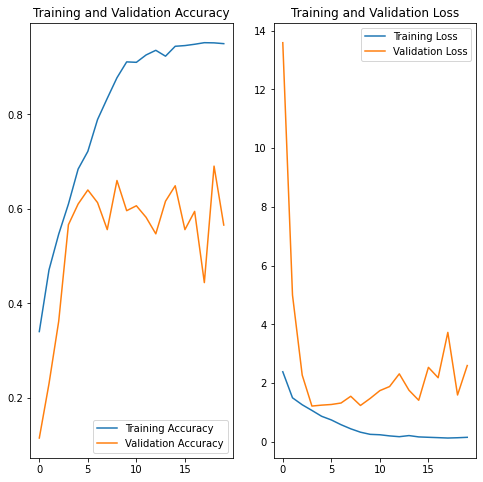

In [ ]:
# Model Definition
model_3 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)])


# Compile model
model_3.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


# Model Summary
model_3.summary()
    
class_weight = {count_im_df.index[0]: (count_im_df['count'].sum()/(9*count_im_df['count'][0])),
                count_im_df.index[1]: (count_im_df['count'].sum()/(9*count_im_df['count'][1])),
                count_im_df.index[2]: (count_im_df['count'].sum()/(9*count_im_df['count'][2])),
                count_im_df.index[3]: (count_im_df['count'].sum()/(9*count_im_df['count'][3])),
                count_im_df.index[4]: (count_im_df['count'].sum()/(9*count_im_df['count'][4])),
                count_im_df.index[5]: (count_im_df['count'].sum()/(9*count_im_df['count'][5])),
                count_im_df.index[6]: (count_im_df['count'].sum()/(9*count_im_df['count'][6])),
                count_im_df.index[7]: (count_im_df['count'].sum()/(9*count_im_df['count'][7])),
                count_im_df.index[8]: (count_im_df['count'].sum()/(9*count_im_df['count'][8]))}
    
# Run model
epochs = 20
history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight = class_weight)


# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_3:Batch Normalization', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

Batch normalization is not improving model any furhter from experiment 1. But we can still try batch normalization with dropout to check its effect on accuracy.

### Experiment 4: Using Dropout & BatchNormalization

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 120, 120, 16)      448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 120, 120, 16)      64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 60, 60, 32)       

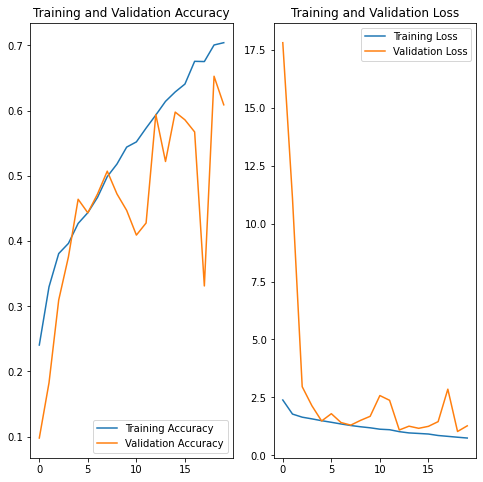

In [ ]:
# Model Definition
model_4 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes)])


# Compile model
model_4.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


# Model Summary
model_4.summary()
    
    
class_weight = {count_im_df.index[0]: (count_im_df['count'].sum()/(9*count_im_df['count'][0])),
                count_im_df.index[1]: (count_im_df['count'].sum()/(9*count_im_df['count'][1])),
                count_im_df.index[2]: (count_im_df['count'].sum()/(9*count_im_df['count'][2])),
                count_im_df.index[3]: (count_im_df['count'].sum()/(9*count_im_df['count'][3])),
                count_im_df.index[4]: (count_im_df['count'].sum()/(9*count_im_df['count'][4])),
                count_im_df.index[5]: (count_im_df['count'].sum()/(9*count_im_df['count'][5])),
                count_im_df.index[6]: (count_im_df['count'].sum()/(9*count_im_df['count'][6])),
                count_im_df.index[7]: (count_im_df['count'].sum()/(9*count_im_df['count'][7])),
                count_im_df.index[8]: (count_im_df['count'].sum()/(9*count_im_df['count'][8]))}
    
# Run model
epochs = 20
history = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight = class_weight)


# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_4:Batch Normalization & Dropout', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

In [ ]:
pd.DataFrame(results, columns=['exp', 'acc', 'val_acc', 'loss', 'val_loss'])

,exp,acc,val_acc,loss,val_loss
0,exp_0:Vanilla,0.751674,0.521253,0.763039,1.976589
1,exp_1:Vanilla-Aug,0.932863,0.723831,0.188490,1.122861
2,exp_2:Dropout,0.746105,0.680772,0.706130,0.933580
3,exp_3:Batch Normalization,0.949555,0.565702,0.148453,2.593265
4,exp_4:Batch Normalization & Dropout,0.704006,0.608760,0.749887,1.275833


Out of all 4 above experiments, experiment 2 is giving the best results. Experiment 2 is using dropout layers. We would try to extensively solve that model for more epochs and check performance improvement.

### Experiment 5: Using Dropout layer & more training

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 60, 60, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 30, 32)       

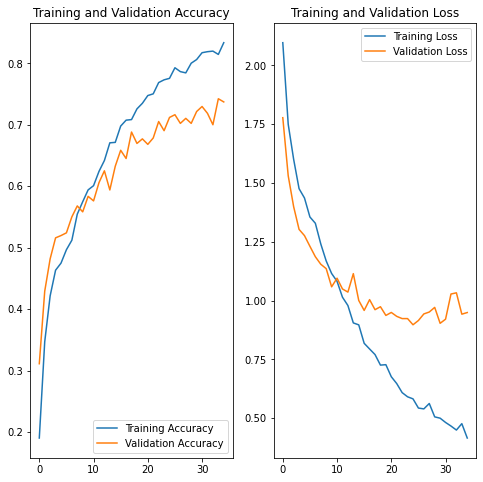

In [ ]:
# Model Definition
model_5 = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes)])


# Compile model
model_5.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


# Model Summary
model_5.summary()
    
    
class_weight = {count_im_df.index[0]: (count_im_df['count'].sum()/(9*count_im_df['count'][0])),
                count_im_df.index[1]: (count_im_df['count'].sum()/(9*count_im_df['count'][1])),
                count_im_df.index[2]: (count_im_df['count'].sum()/(9*count_im_df['count'][2])),
                count_im_df.index[3]: (count_im_df['count'].sum()/(9*count_im_df['count'][3])),
                count_im_df.index[4]: (count_im_df['count'].sum()/(9*count_im_df['count'][4])),
                count_im_df.index[5]: (count_im_df['count'].sum()/(9*count_im_df['count'][5])),
                count_im_df.index[6]: (count_im_df['count'].sum()/(9*count_im_df['count'][6])),
                count_im_df.index[7]: (count_im_df['count'].sum()/(9*count_im_df['count'][7])),
                count_im_df.index[8]: (count_im_df['count'].sum()/(9*count_im_df['count'][8]))}
    
# Run model
epochs = 35
history = model_5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight = class_weight)


# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_5:Dropout (Extensive Training)', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])

In [ ]:
pd.DataFrame(results, columns=['exp', 'acc', 'val_acc', 'loss', 'val_loss'])

,exp,acc,val_acc,loss,val_loss
0,exp_0:Vanilla,0.751674,0.521253,0.763039,1.976589
1,exp_1:Vanilla-Aug,0.932863,0.723831,0.188490,1.122861
2,exp_2:Dropout,0.746105,0.680772,0.706130,0.933580
3,exp_3:Batch Normalization,0.949555,0.565702,0.148453,2.593265
4,exp_4:Batch Normalization & Dropout,0.704006,0.608760,0.749887,1.275833
5,exp_5:Dropout (Extensive Training),0.833642,0.737194,0.415581,0.949111


It can be observed that solving experiment 2 model for larger number of epochs isn't improving the model any further.

### Experiment 6: Transfer Learning

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

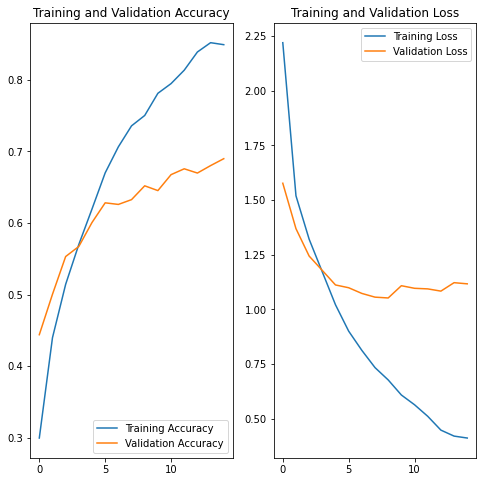

,exp,acc,val_acc,loss,val_loss
0,exp_0:Vanilla,0.751674,0.521253,0.763039,1.976589
1,exp_1:Vanilla-Aug,0.932863,0.723831,0.188490,1.122861
2,exp_2:Dropout,0.746105,0.680772,0.706130,0.933580
3,exp_3:Batch Normalization,0.949555,0.565702,0.148453,2.593265
4,exp_4:Batch Normalization & Dropout,0.704006,0.608760,0.749887,1.275833
5,exp_5:Dropout (Extensive Training),0.833642,0.737194,0.415581,0.949111
6,exp_6: Transfer Learning,0.848850,0.689681,0.411805,1.116732


In [ ]:
def res_model():
  model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False)

  for layer in model.layers:
    layer.trainable = False

  model_output = model.output

  x = tf.keras.layers.GlobalAveragePooling2D()(model_output)
  x = layers.Dense(512, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(num_classes, activation='softmax', name='fcnew')(x)

  model_f = tf.keras.Model(inputs=model.input, outputs=x)

  return model_f

model_6 = res_model()
model_6.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

model_6.summary()

epochs = 15
history = model_6.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs)

# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_6: Transfer Learning', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])
pd.DataFrame(results, columns=['exp', 'acc', 'val_acc', 'loss', 'val_loss'])

In the `Transfer Learning` architecture, we are trying to remove final few fully connected layers of VGG16 architecture and insert some fully connected layers as per our specific problem requirements. We are fixing the weights of the original VGG16 network and only training last few inserted layers.  We have total 329,481 trainable parameters. 

Observation,
- We can observe that improvements in the accuracy and loss values aren't much as compared to dropout based network. 
- For the next experient, we can try to fine tune few of the Conv layers (at lower learning rate) from VGG16 net in order to improve performance.

### Experiment 7: Fine Tuning

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

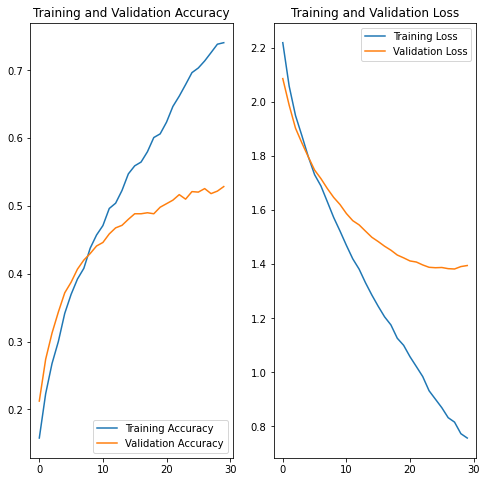

,exp,acc,val_acc,loss,val_loss
0,exp_0:Vanilla,0.685826,0.519016,0.977335,1.721618
1,exp_0:Vanilla,0.272879,0.228188,2.530467,2.259476
2,exp_0:Vanilla,0.267857,0.319911,2.575125,1.952905
3,exp_1:Vanilla-Aug,0.582159,0.482554,1.150216,1.449230
4,exp_1:Vanilla-Aug,0.307307,0.193764,1.862473,2.378580
5,exp_1:Vanilla-Aug,0.754266,0.504083,0.666187,1.760409
6,exp_2:Dropout,0.529859,0.449146,1.279751,1.461174
7,exp_7:Fine Tuning,0.987945,0.604306,0.044209,2.159541
8,exp_7:Fine Tuning,0.424332,0.403118,1.584691,1.612267
9,exp_7:Fine Tuning,0.504822,0.443207,1.355311,1.516610


In [ ]:
def res_model():
  model = tf.keras.applications.ResNet50(include_top = False)

  split_at = 155

  for layer in model.layers[:split_at]: layer.trainable = False
  for layer in model.layers[split_at:]: layer.trainalbe = True

  model_output = model.output

  x = tf.keras.layers.GlobalAveragePooling2D()(model_output)
  x = layers.Dense(32, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(16, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(num_classes, activation='softmax', name='fcnew')(x)

  model_f = tf.keras.Model(inputs=model.input, outputs=x)

  return model_f

model_7 = res_model()
model_7.compile(optimizer=tf.keras.optimizers.SGD(lr = 0.0001, decay = 1e-6, momentum = 0.9, nesterov = True),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

model_7.summary()

epochs = 30
history = model_7.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs)

# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_7:Fine Tuning ', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])
pd.DataFrame(results, columns=['exp', 'acc', 'val_acc', 'loss', 'val_loss'])

In [ ]:
Y_pred = model_7.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(' ')
print(classification_report(test_data.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[1 2 1 2 4 2 0 3 1]
 [0 0 2 2 3 6 0 2 1]
 [1 3 0 1 6 4 0 1 0]
 [1 0 3 1 3 6 0 2 0]
 [1 0 4 1 5 4 0 1 0]
 [1 3 0 2 4 5 0 0 1]
 [1 0 0 0 2 0 0 0 0]
 [1 2 1 2 5 2 0 2 1]
 [0 0 0 0 2 1 0 0 0]]
 
              precision    recall  f1-score   support

           0       0.14      0.06      0.09        16
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        16
           3       0.09      0.06      0.07        16
           4       0.15      0.31      0.20        16
           5       0.17      0.31      0.22        16
           6       0.00      0.00      0.00         3
           7       0.18      0.12      0.15        16
           8       0.00      0.00      0.00         3

    accuracy                           0.12       118
   macro avg       0.08      0.10      0.08       118
weighted avg       0.10      0.12      0.10       118



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

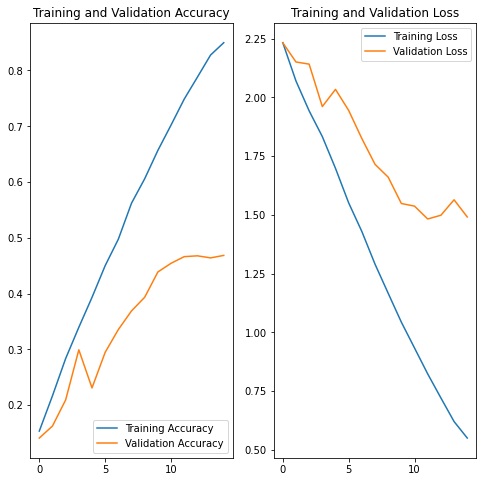

,exp,acc,val_acc,loss,val_loss
0,exp_1:Vanilla-Aug,0.802300,0.507795,0.567560,2.059403
1,exp_7:Fine Tuning,0.849777,0.468448,0.550599,1.491027


In [ ]:
def res_model():
  model = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False)

  split_at = 45

  for layer in model.layers[:split_at]: layer.trainable = False
  for layer in model.layers[split_at:]: layer.trainalbe = True
  # for layer in model.layers:
  #   layer.trainable = False

  model_output = model.output

  x = tf.keras.layers.GlobalAveragePooling2D()(model_output)
  x = layers.Dense(512, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation = 'relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(num_classes, activation='softmax', name='fcnew')(x)

  model_f = tf.keras.Model(inputs=model.input, outputs=x)

  return model_f

model_7 = res_model()
model_7.compile(optimizer=tf.keras.optimizers.SGD(lr = 0.0001, decay = 1e-6, momentum = 0.9, nesterov = True),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

model_7.summary()

epochs = 15
history = model_7.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs)

# Ploting results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results.append(['exp_7:Fine Tuning ', acc[-1], val_acc[-1], loss[-1], val_loss[-1]])
pd.DataFrame(results, columns=['exp', 'acc', 'val_acc', 'loss', 'val_loss'])

In the `Fine Tuning` architecture we are trying to update weights for all the layers starting from `block4_conv2 (Conv2D)`.  We have total 12,128,521 trainable parameters. Here we have used very low learning rate for the optimizer in order to not massive changes to the already build VGG16 network.

Observation,
- We can observe considerable improvements in the accuracy and loss values for both training and validation sets.

### Testing the model

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_data = test_datagen.flow_from_directory('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/',
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 118 images belonging to 9 classes.


In [ ]:
Y_pred = model_5.predict_generator(test_data, 4)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(' ')
print(classification_report(test_data.classes, y_pred))
print(accuracy_score(test_data.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[1 3 1 0 6 4 0 1 0]
 [0 0 1 2 4 8 0 1 0]
 [1 2 2 2 5 3 0 0 1]
 [0 2 0 1 4 3 0 4 2]
 [0 1 1 0 8 3 0 3 0]
 [3 2 1 2 4 3 0 1 0]
 [0 0 0 0 2 0 0 1 0]
 [3 0 1 0 7 5 0 0 0]
 [0 0 0 1 0 2 0 0 0]]
 
              precision    recall  f1-score   support

           0       0.12      0.06      0.08        16
           1       0.00      0.00      0.00        16
           2       0.29      0.12      0.17        16
           3       0.12      0.06      0.08        16
           4       0.20      0.50      0.29        16
           5       0.10      0.19      0.13        16
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3

    accuracy                           0.13       118
   macro avg       0.09      0.10      0.08       118
weighted avg       0.11      0.13      0.10       118

0.1271186440677966


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Y_pred = model_6.predict_generator(test_data, 4)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(' ')
print(classification_report(test_data.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[0 4 1 0 6 3 0 2 0]
 [1 2 3 1 4 3 0 2 0]
 [0 2 2 1 5 2 0 2 2]
 [0 2 2 1 8 2 0 1 0]
 [0 1 1 1 4 3 0 4 2]
 [0 4 3 2 2 5 0 0 0]
 [0 1 0 0 1 1 0 0 0]
 [0 2 3 1 4 3 0 2 1]
 [0 0 0 0 2 0 0 1 0]]
 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.11      0.12      0.12        16
           2       0.13      0.12      0.13        16
           3       0.14      0.06      0.09        16
           4       0.11      0.25      0.15        16
           5       0.23      0.31      0.26        16
           6       0.00      0.00      0.00         3
           7       0.14      0.12      0.13        16
           8       0.00      0.00      0.00         3

    accuracy                           0.14       118
   macro avg       0.10      0.11      0.10       118
weighted avg       0.12      0.14      0.12       118



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Y_pred = model_7.predict_generator(test_data, 4)
y_pred = np.argmax(Y_pred, axis=1)
print(confusion_matrix(test_data.classes, y_pred))
print(' ')
print(classification_report(test_data.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[1 1 3 1 3 6 0 1 0]
 [2 1 2 2 6 2 0 1 0]
 [0 1 1 3 9 1 0 0 1]
 [0 0 0 3 5 6 0 2 0]
 [0 9 0 0 2 3 1 1 0]
 [0 6 2 0 2 4 0 2 0]
 [1 0 0 0 1 1 0 0 0]
 [0 2 0 2 4 3 0 2 3]
 [0 1 0 0 0 1 0 0 1]]
 
              precision    recall  f1-score   support

           0       0.25      0.06      0.10        16
           1       0.05      0.06      0.05        16
           2       0.12      0.06      0.08        16
           3       0.27      0.19      0.22        16
           4       0.06      0.12      0.08        16
           5       0.15      0.25      0.19        16
           6       0.00      0.00      0.00         3
           7       0.22      0.12      0.16        16
           8       0.20      0.33      0.25         3

    accuracy                           0.13       118
   macro avg       0.15      0.13      0.13       118
weighted avg       0.16      0.13      0.13       118



-----------------